In [1]:
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import os
import questionary
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.common import URL
from MCForecastTools import MCSimulation
from datetime import datetime, timedelta

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv(".\\SAMPLE.env")

True

In [ ]:
# Using the YFinance library, make an API call to access the historical prices of Bitcoin over the last three years

In [3]:
btc = yf.Ticker("BTC-USD")

In [4]:
btc_hist = btc.history(period="3y")

In [ ]:
# Collect the Bitcoin data into DataFrame

In [5]:
btc_price_df = pd.DataFrame(btc_hist["Close"])
btc_price_df.dropna().copy()
btc_price_df["Close"] = btc_price_df["Close"].astype("float")

In [ ]:
# Using the YFinance library, make an API call to access the historical prices of S&P 500 ETF over the last three years

In [6]:
spy = yf.Ticker("SPY")

In [7]:
spy_hist = spy.history(period="3y")

In [ ]:
# Collect the S&P 500 ETF data into DataFrame

In [8]:
spy_price_df = pd.DataFrame(spy_hist["Close"])
spy_price_df.dropna().copy()
spy_price_df["Close"] = spy_price_df["Close"].astype("float")

In [ ]:
# Collect the initial investment

In [9]:
#monthly_investment = questionary.text("How much money would you like to invest monthly (50/50 split)?").ask()
monthly_investment = "1800"
monthly_investment = float(monthly_investment)

In [ ]:
# Calculate the Bitcoin initial investment 

In [10]:
btc_investment = monthly_investment / 2
print(f"Monthly BTC Investment: ${btc_investment:.2f}")

Monthly BTC Investment: $900.00


In [ ]:
# Calculate the daily number of Bitcoin coins based on the Bitcoin initial investment

In [11]:
btc_coins_list = []

for price in btc_price_df['Close']:
    btc_coins = btc_investment / price
    btc_coins_list.append(btc_coins)

In [ ]:
# Calculate the total current Bitcoin coins based on recurring monthly investment and collect into DataFrame

In [12]:
btc_price_df['Coins'] = btc_coins_list
btc_coins_df = pd.DataFrame(btc_price_df["Coins"])
btc_coins_df.reset_index(inplace=True)
btc_coins_df = btc_coins_df.rename(columns = {'index':'Date'})

In [13]:
btc_period = btc_coins_df.Date.dt.to_period("M")
avg_btc_coins_df = btc_coins_df.groupby(btc_period)['Coins'].mean()
total_btc_coins = avg_btc_coins_df.sum()
print(f"Total Current Bitcoin Coins: {total_btc_coins:.5f}")

Total Current Bitcoin Coins: 2.08038


In [ ]:
# Calculate the total current Bitcoin wallet in USD using current Bitcoin price

In [14]:
btc_current_price = btc_price_df["Close"].iloc[-1]
print(f"Current Bitcoin Price: ${btc_current_price:.2f}") 
btc_usd_wallet = total_btc_coins * btc_current_price
print(f"Total Current Bitcoin Wallet (USD): ${btc_usd_wallet:.2f}")

Current Bitcoin Price: $21716.25
Total Current Bitcoin Wallet (USD): $45178.04


In [ ]:
# Calculate the S&p 500 ETF initial investment

In [15]:
spy_investment = monthly_investment / 2
print(f"Monthly SPY Investment: ${spy_investment:.2f}")

Monthly SPY Investment: $900.00


In [ ]:
# Calculate the daily number of S&P 500 ETF shares based on the S&P 500 ETF initial investment

In [16]:
spy_shares_list = []

for price in spy_price_df['Close']:
    spy_shares = spy_investment / price
    spy_shares_list.append(spy_shares)
    

In [ ]:
# Calculate the total current S&P 500 ETF shares based on recurring monthly investment and collect into DataFrame

In [17]:
spy_price_df['Shares'] = spy_shares_list
spy_shares_df = pd.DataFrame(spy_price_df["Shares"])
spy_shares_df.reset_index(inplace=True)
spy_shares_df = spy_shares_df.rename(columns = {'index':'Date'})

In [18]:
spy_period = spy_shares_df.Date.dt.to_period("M")
avg_spy_shares_df = spy_shares_df.groupby(spy_period)['Shares'].mean()
total_spy_shares = avg_spy_shares_df.sum()
print(f"Total Current S&P 500 ETF Shares: {total_spy_shares:.5f}")

Total Current S&P 500 ETF Shares: 93.73168


In [ ]:
# Calculate the total current S&P 500 ETF wallet in USD using current S&P 500 ETF price

In [19]:
spy_current_price = spy_price_df["Close"].iloc[-1]
print(f"Current S&P 500 ETF Price: ${spy_current_price:.2f}")  
spy_usd_wallet = total_spy_shares * spy_current_price
print(f"Total Current S&P 500 ETF Wallet (USD): ${spy_usd_wallet:.2f}")

Current S&P 500 ETF Price: $413.67
Total Current S&P 500 ETF Wallet (USD): $38773.98


In [ ]:
# Calculate the total value of portfolio in USD

In [20]:
total_portfolio = btc_usd_wallet + spy_usd_wallet
print(f"Total Value of Portfolio (USD): ${total_portfolio:.2f}")

Total Value of Portfolio (USD): $83952.03


In [ ]:
# Create a savings DataFrame including the Bitcoin and S&P 500 ETF wallets

In [21]:
savings_df = pd.DataFrame(data=[btc_usd_wallet, spy_usd_wallet], columns=['Amount'], index=['Bitcoin', 'S&P 500 ETF'])

<AxesSubplot:title={'center':'Total Value of Portfolio (USD)'}, ylabel='Amount'>

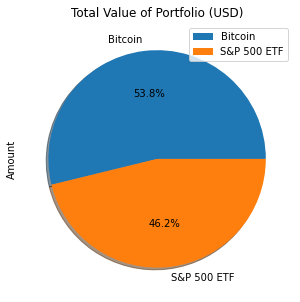

In [22]:
# Plot the total value of the member's portfolio (Bitcoin and S&P 500 ETF) in a pie chart
savings_df.plot.pie(y='Amount',figsize=(5, 5),title="Total Value of Portfolio (USD)",
                    autopct='%1.1f%%', shadow=True, startangle=0)

In [23]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca tradeapi.REST object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    URL('https://paper-api.alpaca.markets'),
    api_version = "v2"
)

In [24]:
# Set timeframe to 1Day
timeframe = "1Day"

# Set start and end dates of 3 years back from yesterday's date
today = datetime.today()
yesterday = today - timedelta(days=1)
three_years = today - timedelta(days=756)

sDateStr = three_years.strftime("%Y-%m-%d")
eDateStr = yesterday.strftime("%Y-%m-%d")

start_date = pd.Timestamp(sDateStr, tz="America/New_York").isoformat()
end_date = pd.Timestamp(eDateStr, tz="America/New_York").isoformat()

In [25]:
# Use the Alpaca get_bars function to get current closing prices of S&P 500 ETF
spy_data = api.get_bars(
    ["SPY"],
    timeframe,
    start_date,
    end_date
).df

# Reorganize the S&P 500 ETF DataFrame
spy_data.index = spy_data.index.strftime('%Y-%m-%d')
SPY = spy_data[spy_data['symbol']=='SPY'].drop('symbol', axis=1)


# Review the first 5 rows of the Alpaca DataFrame
SPY.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2020-07-29,322.14,325.73,322.075,325.12,48454159,275881,323.937307
2020-07-30,321.90,324.41,319.640,323.96,61861788,397283,322.845066
2020-07-31,326.00,326.63,321.330,326.52,85211555,448876,324.494578
2020-08-03,328.31,329.62,327.730,328.79,53078112,288003,328.658795
2020-08-04,327.88,330.06,327.860,330.06,41917896,250899,329.057592


In [26]:
# Use the Alpaca get_crypto_bars function to get current closing prices of Bitcoin
bitcoin_data = api.get_crypto_bars(
     ["BTCUSD"], 
     timeframe,
     start_date,
     end_date
).df

# Reorganize the Bitcoin DataFrame
bitcoin_data.index = bitcoin_data.index.strftime('%Y-%m-%d')
BTC = bitcoin_data[bitcoin_data['exchange']=='CBSE'].drop(['exchange','symbol'], axis=1)

# Review the first 5 rows of the Alpaca DataFrame
BTC.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2020-07-29,10951.76,11350.00,10920.01,11110.12,15426.566781,109844,11153.892818
2020-07-30,11115.99,11148.28,10975.00,11067.62,1948.135936,23599,11031.741379
2020-07-31,11067.63,11460.00,11044.49,11351.62,13697.898587,107668,11275.251680
2020-08-01,11810.07,12134.29,10546.15,11181.02,10591.070823,57333,11513.096397
2020-08-02,11182.60,11426.55,10931.81,11068.54,15005.515882,107041,11196.270295


In [ ]:
# Combine Bitcoin and S&P 500 ETF DataFrames into one DataFrame and remove any null values

In [27]:
prices_df = pd.concat([BTC,SPY],axis=1, keys=['BTC','SPY'])
prices_df = prices_df.dropna().copy()

# Review the first 5 rows of the Alpaca DataFrame
prices_df.head()

BTC                                                          \
                open      high       low     close        volume trade_count   
timestamp                                                                      
2020-07-29  10951.76  11350.00  10920.01  11110.12  15426.566781    109844.0   
2020-07-30  11115.99  11148.28  10975.00  11067.62   1948.135936     23599.0   
2020-07-31  11067.63  11460.00  11044.49  11351.62  13697.898587    107668.0   
2020-08-03  11233.16  11417.11  11222.00  11319.07   2337.001514     26352.0   
2020-08-04  11197.05  11265.74  11073.70  11253.61   1926.660006     19656.0   

                             SPY                                       \
                    vwap    open    high      low   close      volume   
timestamp                                                               
2020-07-29  11153.892818  322.14  325.73  322.075  325.12  48454159.0   
2020-07-30  11031.741379  321.90  324.41  319.640  323.96  61861788.0   
2020-07-31  11275.251680  326.00  326.63  321.330  326.52  85211555.0   
2020-08-03  11319.548902  328.31  329.62  327.730  328.79  53078112.0   
2020-08-04  11185.480901  327.88  330.06  327.860  330.06  41917896.0   

                                    
           trade_count        vwap  
timestamp                           
2020-07-29    275881.0  323.937307  
2020-07-30    397283.0  322.845066  
2020-07-31    448876.0  324.494578  
2020-08-03    288003.0  328.658795  
2020-08-04    250899.0  329.057592

In [ ]:
# Configure the Monte Carlo simulation to forecast 10 years cumulative returns
# The weights should be split 80% to BTC and 20% to SPY.
# Run 500 samples

In [28]:
MC_tenyear_aggressive = MCSimulation(
    portfolio_data=prices_df,
    weights=[0.80, 0.20],
    num_simulation=500,
    num_trading_days=252*10,
)

# Review the simulation input data
MC_tenyear_aggressive.portfolio_data

BTC                                                          \
                open      high       low     close        volume trade_count   
timestamp                                                                      
2020-07-29  10951.76  11350.00  10920.01  11110.12  15426.566781    109844.0   
2020-07-30  11115.99  11148.28  10975.00  11067.62   1948.135936     23599.0   
2020-07-31  11067.63  11460.00  11044.49  11351.62  13697.898587    107668.0   
2020-08-03  11233.16  11417.11  11222.00  11319.07   2337.001514     26352.0   
2020-08-04  11197.05  11265.74  11073.70  11253.61   1926.660006     19656.0   
...              ...       ...       ...       ...           ...         ...   
2022-08-16  23962.61  24153.58  23668.00  24069.75  18926.543068    622752.0   
2022-08-17  24072.26  24448.49  23180.14  23379.04  21507.482650    556575.0   
2022-08-18  23379.04  23600.00  22712.22  22787.49  16656.303422    577763.0   
2022-08-19  22789.49  22835.53  20782.39  21244.91  46606.469108   1004800.0   
2022-08-22  21468.33  21540.00  20889.69  21266.93  25643.744102    694327.0   

                                          SPY                           \
                    vwap daily_return    open    high      low   close   
timestamp                                                                
2020-07-29  11153.892818          NaN  322.14  325.73  322.075  325.12   
2020-07-30  11031.741379    -0.003825  321.90  324.41  319.640  323.96   
2020-07-31  11275.251680     0.025660  326.00  326.63  321.330  326.52   
2020-08-03  11319.548902    -0.002867  328.31  329.62  327.730  328.79   
2020-08-04  11185.480901    -0.005783  327.88  330.06  327.860  330.06   
...                  ...          ...     ...     ...      ...     ...   
2022-08-16  23917.823725     0.004467  427.62  431.73  426.880  429.70   
2022-08-17  23599.210786    -0.028696  425.94  429.50  424.540  426.65   
2022-08-18  23232.073186    -0.025303  426.78  428.61  425.500  427.89   
2022-08-19  21446.285151    -0.067694  424.87  425.26  421.220  422.14   
2022-08-22  21220.571293     0.001036  417.04  417.23  412.400  413.35   

                                                             
                volume trade_count        vwap daily_return  
timestamp                                                    
2020-07-29  48454159.0    275881.0  323.937307          NaN  
2020-07-30  61861788.0    397283.0  322.845066    -0.003568  
2020-07-31  85211555.0    448876.0  324.494578     0.007902  
2020-08-03  53078112.0    288003.0  328.658795     0.006952  
2020-08-04  41917896.0    250899.0  329.057592     0.003863  
...                ...         ...         ...          ...  
2022-08-16  59118566.0    410281.0  429.307919     0.001959  
2022-08-17  63266564.0    451881.0  426.965059    -0.007098  
2022-08-18  47948507.0    331980.0  427.137042     0.002906  
2022-08-19  67861630.0    438953.0  423.097019    -0.013438  
2022-08-22  77604197.0    484052.0  415.048519    -0.020822  

[522 rows x 16 columns]

In [29]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear_aggressive.calc_cumulative_return()

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

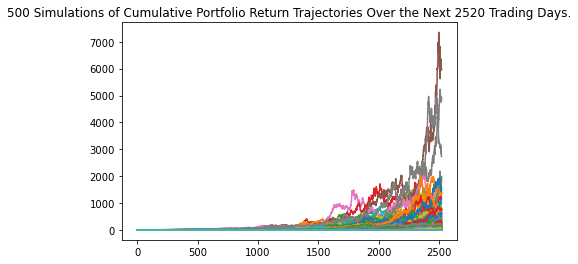

In [34]:
# Visualize the 10-year Monte Carlo simulation by creating an
# overlay line plot
MC_tenyear_aggressive.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

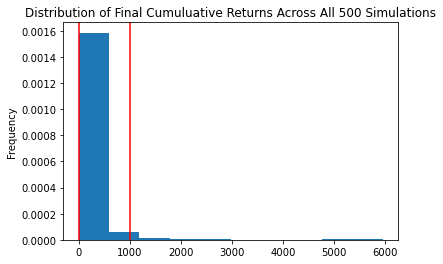

In [35]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation
MC_tenyear_aggressive.plot_distribution()

In [32]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable
MC_tenyear_statistics = MC_tenyear_aggressive.summarize_cumulative_return()


# Review the 10-year Monte Carlo summary statistics
print(MC_tenyear_statistics)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

In [33]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current crypt/stock portfolio
ci_lower_ten_cumulative_return = round(MC_tenyear_statistics[8]*monthly_investment,2)
ci_upper_ten_cumulative_return = round(MC_tenyear_statistics[9]*monthly_investment,2)

# Print the result of your calculations
print(f"There is a 95% chance that an initial investment of"
      f" ${monthly_investment:.2f} in the portfolio"
      f" over the next 10 years will end within the range of"
      f" ${ci_lower_ten_cumulative_return} and ${ci_upper_ten_cumulative_return}.")

There is a 95% chance that an initial investment of $1800.00 in the portfolio over the next 10 years will end within the range of $1624.45 and $1807264.23.
